In [5]:
!pip install --force-reinstall "casadi==3.5.5"
!pip install scipy
!pip install celluloid #convenient package for making animations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 19.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import time
import casadi as ca
import numpy as np
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import pdb
from random import sample
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
from IPython.display import HTML
from celluloid import Camera                  


## Simulator
The class defines the Highway environment. It simulates the Ego Vehicle (EV) and Target Vehicle (TV) with LTI system dynamics, and also includes the mode-dependent control logic for the TV. It also has a prediction module that can be used for the constraints in the Stochastic MPC defined ahead.

In [7]:

class Simulator():
    '''
    
    Simulates a Highway with 1 Ego vehicle (EV) and 1 target vehicles (TVs).
    The TVs can be in one of two modes: drive straight or change into EV's lane

    '''

    def __init__(self,
                DT          = 0.2,
                T_FINAL     = 300,
                MODE        = 0,
                S_FINAL     = 50,
                TV_SPEED    = 14.,
                TV_L        = 1.5,
                EV_INIT     = [-35., 0., 14.],
                TV_INIT     = [[-24.,8.,0.]], 
                NOISE_STD   = [0.01, 0.01, 0.05, 0.01], #EV_X, EV_V, TV_Y, TV_Psi 
                EV_POLICY_TYPE = "SMPC_IA",
                IA_flag= False
                ):

        self.ev_pol=EV_POLICY_TYPE
        self.IA_flag=IA_flag

        self.t=0
        self.dt= DT
        self.T=T_FINAL

        # Half length and half width of the cars
        self.hl=2.9
        self.hw=1.6

        # EV states: x,y,v_x
        self.A=np.array([[1., 0., self.dt],[0., 1., 0.], [0., 0., 1.]])
        self.B=np.array([0.,0.,self.dt])

        self.u_prev=0.

        self.tv_v=TV_SPEED
        self.tv_l=TV_L

        self.ev_init=np.array(EV_INIT)
        self.ev_traj=np.zeros((3,self.T+1))
        self.ev_u=np.zeros((1,self.T))
        self.ev_traj[:,0]=self.ev_init

        
        self.N_modes=2
        ## mode = 0, TV straight
        ## mode = 1, TV changes lane
        self.mode=MODE
        
        
        # TV states: x,y,psi
        self.Atv=np.array([[1., 0., 0.],[0., 1., float(self.mode)*self.tv_v*self.dt], [0., 0., 1.]])
        self.Btv=np.array([0.,0.,self.tv_v/2/self.tv_l*self.dt]) 
        
        self.N_TV=len(TV_INIT)
        self.tv_init= [np.array(TV_INIT[k]) for k in range(self.N_TV)]
        

        # Control gains for TV: straight policy, lane change policy
        self.gains=[[0.,0.], [.015,.6]]
        politeness=0.6
        self.IA_gains=[politeness,1-politeness]

        

        self.s_f=50.
        # o_c1, o_c2 are controller parameters for the TV
        # o_c1 is a parameter used in the IA controller
        # o_c2 denotes the desired lateral coordinate
        self.o_c1=10.
        self.o_c2=0.
        

        self.tv_traj=[np.zeros((3,self.T+1)) for k in range(self.N_TV)]

        for k in range(self.N_TV):
            self.tv_traj[k][:,0]=self.tv_init[k]
        
        self.noise_std=NOISE_STD


    def done(self):
        return self.t==self.T or self.s_f-self.ev_traj[0,self.t]<=0.1

    def get_update_dict(self, N, *args):

        if self.t==0:
            z_lin=[np.array([self.ev_traj[:,self.t]]*(N+1)).T]*self.N_modes
            u_tvs=[[np.zeros(N) for j in range(self.N_modes)] for k in range(self.N_TV)]
            elim_mode=0. 
            ev_cross=0.
        else:
            z_lin, u_tvs, elim_mode, ev_cross =self._get_preds(N, *args)

        update_dict={'x0': self.ev_traj[0,self.t], 'y0': self.ev_traj[1,self.t], 'v0':self.ev_traj[2,self.t], 'u_prev':self.u_prev,
                     'x_tv0': np.array([self.tv_traj[k][0,self.t] for k in range(self.N_TV)]), 'y_tv0': np.array([self.tv_traj[k][1,self.t] for k in range(self.N_TV)]), 'v_tv0': np.array([self.tv_traj[k][2,self.t] for k in range(self.N_TV)]),
                     'z_lin': z_lin, 'u_tvs': u_tvs, 'elim_mode': elim_mode, 'ev_cross': ev_cross}

        return update_dict


    def run_step(self, u_ev):

        rng=np.random.default_rng(self.t)

        self.ev_traj[:,self.t+1]=self.A@self.ev_traj[:,self.t]+self.B*u_ev\
                                    +np.array([rng.normal(0,self.noise_std[0]), 0., rng.normal(0,self.noise_std[1])])
        self.ev_traj[2,self.t+1]=np.max([.0, self.ev_traj[2,self.t+1] ])
        self.ev_u[:,self.t]=u_ev
        self.u_prev=u_ev
        u_tv=[]

        ## The following defines the corresponding controller for each TV,
        ## depending on the mode and whether they are interaction aware (IA) or not

        if not self.IA_flag : 
            ## This is non-interactive case. The TV's control actions are not 
            ## affected by EV.

            ## Implements controller corresponding to the mode

            if self.mode==0: 
                #TV1 keeps current speed
                u_tv.append(0.)
            else:            
                #TV1 changes into EV's lane
                u_tv.append(self.gains[1][0]*(self.o_c2-self.tv_traj[0][1,self.t])
                            +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))
        else:
            ## This is the interactive case. For the lane change mode(=1), the
            ## the TV's lateral speed is decreased when the EV is close

            if self.mode==0: 
                #TV1 keeps current speed, same as non-IA case
                u_tv.append(0.)
            else:            
                #TV1 changes into EV's lane
                if self.ev_traj[0,self.t]<=self.tv_traj[0][0,self.t]+3. and self.ev_traj[0,self.t]>=self.tv_traj[0][0,self.t]-self.o_c1:
                    # If the EV is within [-10m, 3m] of the TVs longitudinal coordinate, 
                    # a linear term that depends on the EV and TV positions is added. 
                    # This term pushes the TV into it's lane.
                    u_tv.append(self.gains[1][0]*(self.IA_gains[0]*(self.o_c1+self.ev_traj[0,self.t]-self.tv_traj[0][0,self.t])
                                                  +self.IA_gains[1]*(self.o_c2-self.tv_traj[0][1,self.t]))
                                +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))
                else:
                    # Otherwise, changes into EV's lane as in the non-IA case
                    u_tv.append(self.gains[1][0]*( self.o_c2-self.tv_traj[0][1,self.t])
                                +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))

        for k in range(self.N_TV):
            self.tv_traj[k][:,self.t+1]=self.Atv@self.tv_traj[k][:,self.t]+self.Btv*u_tv[k]\
                                            +np.array([self.tv_v*self.dt, 0.1*rng.normal(0,self.noise_std[2]), 0.1*rng.normal(0,self.noise_std[3])])

        self.t+=1


    def _get_preds(self, N, *args):
        '''
        Getting EV predictions from previous MPC solution.
        This is used for linearizing the collision avoidance constraints
        '''

        # The disturbance that hit the EV in the previous time step
        w=np.diag(np.array(self.noise_std[0:2])**(-1))@(self.ev_traj[0::2,self.t]-self.A[0::2,:]@self.ev_traj[:,self.t-1]-self.B[0::2]*self.u_prev)

        # Current states of the EV and TV
        x0=[self.ev_traj[:,self.t] for j in range(self.N_modes)]
        o0=[[self.tv_traj[k][:,self.t] for k in range(self.N_TV)] for j in range(self.N_modes)]

        elim_mode=False
        ev_cross=False

        ## Thw following flags are used to prune modes that are unlikely, given
        ## the current states of the EV and TV

        if o0[0][0][1]<4:
            ## The EV's lane occupies y=-5 to y=4. If the TV's y-position has 
            ## has crossed into the EV's lane, the TV's lane keeping mode(=0) is
            ## eliminated
            elim_mode=True

        if x0[0][0]>o0[0][0][0]+3.:
            ## Records if the EV has passed ahead of the TV.
            ev_cross=True


        ## The following predictions are generated from the previous MPC solution,
        ## specifically for the open-loop, and disturbance-feedback based SMPC
        ## controllers.

        ## For the IA-case, the TV is modelled as a part of the state space within
        ## the SMPC class itself.

        x_lin=[np.zeros((3,N+1)) for j in range(self.N_modes)]
        u_tvs=[[np.zeros(N) for j in range(self.N_modes)] for k in range(self.N_TV)]

        for j in range(self.N_modes):
            x=x0[j]
            o=o0[j]
            x_lin[j][:,0]=x   
            w_seq=np.zeros(2*N)
            w_seq[:2]=w
            
            Atv=np.array([[1., 0., 0.],[0., 1., float(j)*self.tv_v*self.dt], [0., 0., 1.]])

            if len(args)==0:
                h_opt=np.zeros((N,1))
                M_opt=np.zeros((N,2*N))
                K_opt=[np.zeros((N,2*N))]*self.N_TV
            else:
                [h_opt, M_opt, K_opt, nom_x_tv]=args

                for t in range(1,N):

                    u=h_opt[j][t]+M_opt[j][t,:]@w_seq+np.sum([K_opt[j][l][t,2*t:2*(t+1)]@(o[l][1:]-nom_x_tv[j][l][1:,t]) for l in range(self.N_TV)])

                   
                    if j==0 and not elim_mode:
                        u_tvs[0][j][t-1]=0.
                    else:
                        u_tvs[0][j][t-1]=self.gains[1][0]*( self.o_c2-o[0][1])+self.gains[1][1]*( 0.-o[0][2])
                    
                    o=[Atv@o[k]+self.Btv*u_tvs[k][j][t-1]+np.array([self.tv_v*self.dt,0.,0.]) for k in range(self.N_TV)]

                    if t==N-1:
                        if j==0 and not elim_mode:
                            u_tvs[0][j][t-1]=0.
                        else:
                            u_tvs[0][j][t-1]=self.gains[1][0]*( self.o_c2-o[0][1])+self.gains[1][1]*( 0.-o[0][2])


                    x=self.A@x+self.B*u
                    x_lin[j][:,t]=x
                    x_lin[j][:,t+1]=self.A@x #constant speed prediction for (N+1)th state 



        return x_lin, u_tvs, float(elim_mode), float(ev_cross)


    def check_collision(self):

        x_disjoint_ev_tv1= (self.ev_traj[0,self.t]+self.hl<self.tv_traj[0][0,self.t]-self.hl) or \
                          (self.tv_traj[0][0,self.t]+self.hl<self.ev_traj[0,self.t]-self.hl)
        y_disjoint_ev_tv1= (self.ev_traj[1,self.t]+self.hw<self.tv_traj[0][1,self.t]-self.hw) or \
                          (self.tv_traj[0][1,self.t]+self.hw<self.ev_traj[1,self.t]-self.hw)

        collision= (not x_disjoint_ev_tv1) and (not y_disjoint_ev_tv1)


        return collision

# Stochastic MPC
This class combines various SMPC implementations for collsion avoidance in the Highway environment. 
The implementations differ in how predictions are handled along the horizon: 

     a) Predictions using open-loop sequences,
     b) Predictions using policies,
     c) Interaction-Aware predictions (EV-TV coupled dynamics)

The collision avoidance constraints are formulated by obtaining a half space inner approximation of the free space, with both vehicles modelled as ellipses.


In [37]:
class SMPC_MMPreds():

    def __init__(self,
                N            =  12,
                DT           = 0.1,
                V_MIN        = -1.,      #Speed, acceleration constraints
                V_MAX        = 16.0, 
                A_MIN        = -5.0,
                A_MAX        =  4.0, 
                N_modes      =  4,
                N_TV         =  2,
                TIGHTENING   =   3.5,      #inverse CDF of standard normal, CDF^{-1}(1-\epsilon)
                NOISE_STD    =  [0.001, 0.001, 0.002, 0.002], # process noise standard deviations in order [w_x, w_y, w_theta, w_v, w_TV] 
                O_const1      =  20, 
                O_const2       =  6.,
                TV_GAINS     =  [[.1,0.2], [2,2]],
                IA_GAINS     =  [0.01, 0.1],
                TV_SPEED     =  8.,
                TV_L         =  2.,
                Q = 200.,       # cost for measuring progress: -Q*s_{t+1}.
                R = 100.,       # cost for penalizing large input rate: POW^t*(u_{t+1}-u_t).T@R@(u_{t+1}-u_t) 
                Probs= [0.5, 0.5],
                POLICY     = "SMPC",
                TV_IA      =False, 
                COLAB      =True,
                CVX        =False
                ):
        self.N=N
        self.DT=DT
        self.V_MIN=V_MIN
        self.V_MAX=V_MAX
        self.A_MAX=A_MAX
        self.A_MIN=A_MIN
        self.N_modes=N_modes
        self.probs=Probs
        self.N_TV=N_TV
        
        self.colab=COLAB
        self.cvx=CVX
  
        self.tight=TIGHTENING
        self.noise_std=NOISE_STD
        self.o_c1=O_const1
        self.o_c2=O_const2

        self.gains=[[0.,TV_GAINS[0][0], TV_GAINS[0][1]], [0.,TV_GAINS[1][0], TV_GAINS[1][1]]]
        self.ia_gain=[IA_GAINS[0], IA_GAINS[1]]

        self.tv_v=TV_SPEED
        self.tv_l=TV_L

        self.Q = ca.diag(Q)
        self.R = ca.diag(R)
        self.pol=POLICY
        self.tv_ia=TV_IA

        self.A=ca.DM([[1., 0., self.DT],[0., 1., 0.], [0., 0., 1.]])
        self.B=ca.DM([0.,0.,self.DT])
        
        #Square root of shape matrices of vehicles
        self.S=ca.diag([1/(3.0),1/(1.7)])

        
        self.Btv=np.array([0.,0.,self.tv_v/2/self.tv_l*self.DT])
        self.Ctv=np.array([self.tv_v*self.DT,0.,0.])

        p_opts = {'expand':False, 'print_time':0, 'verbose' :False, 'error_on_fail':0}
        s_opts = {'sb': 'yes', 'print_level': 0, 'tol': 1e-3, 'honor_original_bounds': 'yes', 'max_iter': 3000} 
        if self.colab:
            s_opts.update({'max_iter': 3000})
        
#         Options for Gurobi
        s_opts_grb = {'OutputFlag': 0, 'FeasibilityTol' : 1e-2, 'PSDTol' : 1e-3}
        p_opts_grb = {'error_on_fail':0}
        
        if not self.cvx:
            self.opti=ca.Opti()
            self.opti.solver("ipopt", p_opts, s_opts)
        else:    
            self.opti=ca.Opti("conic")
            self.opti.solver("gurobi", p_opts_grb, s_opts_grb)

        self.z_curr=self.opti.parameter(3)
        self.u_prev=self.opti.parameter(1)
        self.z_tv_curr=self.opti.parameter(3*self.N_TV)
        self.z_lin=[self.opti.parameter(3,self.N+1) for j in range(self.N_modes)]
        self.u_tvs=[[self.opti.parameter(self.N,1) for j in range(self.N_modes)] for k in range(self.N_TV)]

       

        self.elim_mode=self.opti.parameter(1)
        self.ev_cross=self.opti.parameter(1)
        self.slack_xu=self.opti.variable(1)
        self.slack_ca=self.opti.variable(1)

        self.policy=self._return_policy_class()
        self._add_constraints_and_cost()

        self._update_ev_initial_condition(0., 10., 0., 0. )
        self._update_tv_initial_condition(self.N_TV*[25.], self.N_TV*[10.], self.N_TV*[0.], self.N_TV*[self.N_modes*[np.zeros(self.N)]], 0., 0. )
        self._update_ev_preds(self.N_modes*[np.zeros((3,self.N+1))])            

    def _return_policy_class(self):
        """
        EV Affine disturbance feedback + TV state feedback policies from https://arxiv.org/abs/2109.09792
        """ 
        h0=self.opti.variable(1)
        
        if self.tv_ia:
            if "OL" not in self.pol:
                # Uncomment next line for disturbance feedback when using Gurobi. Runs slow with Ipopt (default)
#                 M=[[[self.opti.variable(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                M=[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[[self.opti.variable(1, 2) for n in range(t)] for t in range(self.N)] for k in range(self.N_TV)] for j in range(self.N_modes)]
                h=[[self.opti.variable(1) for t in range(self.N-1)] for j in range(self.N_modes)]


            else:
                M=[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for k in range(self.N_TV)] for j in range(self.N_modes)]
                h=[[self.opti.variable(1) for t in range(self.N-1)]]*self.N_modes
                
            h_stack=[ca.vertcat(h0,*[h[j][t] for t in range(self.N-1)]) for j in range(self.N_modes)]
            M_stack=[ca.vertcat(*[ca.horzcat(*[M[j][t][n] for n in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for j in range(self.N_modes)]
            K_stack=[[ca.vertcat(*[ca.horzcat(*[K[j][k][t][n] for n in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for k in range(self.N_TV)] for j in range(self.N_modes)] 
        else:
            if "OL" not in self.pol:
                # Uncomment next line for disturbance feedback when using Gurobi. 
                # Runs slow with Ipopt (default)
#                 M=[[[self.opti.variable(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                M=[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[self.opti.variable(1,2) for t in range(self.N-1)] for k in range(self.N_TV)] for j in range(self.N_modes)]
                h=[[self.opti.variable(1) for t in range(self.N-1)] for j in range(self.N_modes)]
            else:
                M=[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[ca.DM(1, 2) for t in range(self.N-1)] for k in range(self.N_TV)] for j in range(self.N_modes)]
                h=[[self.opti.variable(1) for t in range(self.N-1)]]*self.N_modes
            
            h_stack=[ca.vertcat(h0,*[h[j][t] for t in range(self.N-1)]) for j in range(self.N_modes)]
            M_stack=[ca.vertcat(*[ca.horzcat(*[M[j][t][n] for n in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for j in range(self.N_modes)]
            K_stack=[[ca.diagcat(ca.DM(1,2),*[K[j][k][t] for t in range(self.N-1)]) for k in range(self.N_TV)] for j in range(self.N_modes)]

        return h_stack,M_stack,K_stack


    def _get_ATV_TV_dynamics(self):
        """
        Constructs system matrices such that for mode j and for TV k,
        O_t=T_tv@o_{t|t}+T_ev@X_t+c_tv+E_tv@N_t   (T_ev=O for interaction-agnostic case)
        where
        O_t=[o_{t|t}, o_{t+1|t},...,o_{t+N|t}].T, (TV state predictions)
        X_t=[x_{t|t}, x_{t+1|t},...,x_{t+N|t}].T, (EV state predictions)
        N_t=[n_{t|t}, n_{t+1|t},...,n_{t+N-1|t}].T,  (TV process noise sequence)
        o_{i|t}= state prediction of kth vehicle at time step i, given current time t
        """ 
        
        E=ca.DM([[0., 0.],[self.noise_std[2], 0.],[0., self.noise_std[3]]])

        T_tv=[[ca.MX(3*(self.N+1), 3) for k in range(self.N_TV)] for j in range(self.N_modes)]
        T_ev=[[ca.MX(3*(self.N+1), 3*(self.N+1)) for k in range(self.N_TV)] for j in range(self.N_modes)]
        TB_tv=[[ca.MX(3*(self.N+1), self.N) for k in range(self.N_TV)] for j in range(self.N_modes)]
        TC_tv=[[ca.MX(3*(self.N+1), 3) for k in range(self.N_TV)] for j in range(self.N_modes)]
        c_tv=[[ca.MX(3*(self.N+1), 1) for k in range(self.N_TV)] for j in range(self.N_modes)]
        E_tv=[[ca.MX(3*(self.N+1),self.N*2) for k in range(self.N_TV)] for j in range(self.N_modes)]

        u_tvs=self.u_tvs

        for k in range(self.N_TV):
            for j in range(self.N_modes):
                Atv=np.array([[1., 0., 0.],[0., 1., float(j)*self.tv_v*self.DT], [0., 0., 1.]])
                if not self.tv_ia:
                    ## For the non-IA cases, use the TV input predictions to construct
                    ## system matrices
                    for t in range(self.N+1):
                        if t==0:
                            T_tv[j][k][:3,:]=ca.DM.eye(3)
                        else:
                            T_tv[j][k][t*3:(t+1)*3,:]=Atv@T_tv[j][k][(t-1)*3:t*3,:]
                            TB_tv[j][k][t*3:(t+1)*3,:]=Atv@TB_tv[j][k][(t-1)*3:t*3,:]
                            TB_tv[j][k][t*3:(t+1)*3,t-1:t]=self.Btv
                            TC_tv[j][k][t*3:(t+1)*3,:]=ca.DM.eye(3)+Atv@TC_tv[j][k][(t-1)*3:t*3,:]
                            E_tv[j][k][t*3:(t+1)*3,:]=Atv@E_tv[j][k][(t-1)*3:t*3,:]    
                            E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E

                    c_tv[j][k]=TB_tv[j][k]@u_tvs[k][j]+TC_tv[j][k]@self.Ctv

                else:
                    ## For the IA case, construct matrices with the TV's feedback
                    ## controller in the loop.
                    for t in range(self.N+1):
                        if t==0:
                            T_tv[j][k][:3,:]=ca.DM.eye(3)
                        else:
                            if j==0:
                                gain=(1.-self.elim_mode)*ca.DM(self.gains[0]).T+self.elim_mode*((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T)
                                T_tv[j][k][t*3:(t+1)*3,:]=(Atv-self.Btv@gain)@T_tv[j][k][(t-1)*3:t*3,:]
                                T_ev[j][k][t*3:(t+1)*3,:]=(Atv-self.Btv@gain)@T_ev[j][k][(t-1)*3:t*3,:]
                                T_ev[j][k][t*3:(t+1)*3,(t-1)*3:t*3]=self.elim_mode*self.Btv@((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],0.,0.]).T)
                                c_tv[j][k][t*3:(t+1)*3,:]=self.Ctv+self.elim_mode*self.Btv@((1-self.ev_cross)*ca.DM([self.ia_gain[0]*self.gains[1][0], self.ia_gain[1]*self.gains[1][1], 0.]).T+self.ev_cross@ca.DM(self.gains[1]).T)@ca.DM([self.o_c1,self.o_c2, 0.])+(Atv-self.Btv@gain)@c_tv[j][k][(t-1)*3:t*3,:]
                                E_tv[j][k][t*3:(t+1)*3,:]=(Atv-self.Btv@gain)@E_tv[j][k][(t-1)*3:t*3,:]
                                E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E
                            else:
                                gain=((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T)
                                T_tv[j][k][t*3:(t+1)*3,:]=(Atv-self.Btv@gain)@T_tv[j][k][(t-1)*3:t*3,:]
                                T_ev[j][k][t*3:(t+1)*3,:]=(Atv-self.Btv@gain)@T_ev[j][k][(t-1)*3:t*3,:]
                                T_ev[j][k][t*3:(t+1)*3,(t-1)*3:t*3]=self.Btv@((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],0.,0.]).T)
                                c_tv[j][k][t*3:(t+1)*3,:]=self.Ctv+self.Btv@((1-self.ev_cross)*ca.DM([self.ia_gain[0]*self.gains[1][0], self.ia_gain[1]*self.gains[1][1], 0.]).T+self.ev_cross@ca.DM(self.gains[1]).T)@ca.DM([self.o_c1,self.o_c2, 0.])+(Atv-self.Btv@gain)@c_tv[j][k][(t-1)*3:t*3,:]
                                E_tv[j][k][t*3:(t+1)*3,:]=(Atv-self.Btv@gain)@E_tv[j][k][(t-1)*3:t*3,:]
                                E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E


        return T_tv, c_tv, E_tv, T_ev


    def _get_LTV_EV_dynamics(self):
        """
        Constructs system matrices such for EV,
        X_t=A_pred@x_{t|t}+B_pred@U_t+E_pred@W_t
        where
        X_t=[x_{t|t}, x_{t+1|t},...,x_{t+N|t}].T, (EV state predictions)
        U_t=[u_{t|t}, u_{t+1|t},...,u_{t+N-1|t}].T, (EV control sequence)
        W_t=[w_{t|t}, w_{t+1|t},...,w_{t+N-1|t}].T,  (EV process noise sequence)
        x_{i|t}= state prediction of kth vehicle at time step i, given current time t
        """ 

        E=ca.DM([[self.noise_std[0], 0.], [0., 0.], [0., self.noise_std[1]]])

        A_pred=ca.DM(3*(self.N+1), 3)
        B_pred=ca.DM(3*(self.N+1),self.N)
        E_pred=ca.DM(3*(self.N+1),self.N*2)
        A_pred[:3,:]=ca.DM.eye(3)

        for t in range(1,self.N+1):
                A_pred[t*3:(t+1)*3,:]=self.A@A_pred[(t-1)*3:t*3,:]

                B_pred[t*3:(t+1)*3,:]=self.A@B_pred[(t-1)*3:t*3,:]
                B_pred[t*3:(t+1)*3,t-1]=self.B

                E_pred[t*3:(t+1)*3,:]=self.A@E_pred[(t-1)*3:t*3,:]
                E_pred[t*3:(t+1)*3,(t-1)*2:t*2]=E

        return A_pred,B_pred,E_pred

    def _add_constraints_and_cost(self):
        """
        Constructs obstacle avoidance, state-input constraints for Stochastic MPC, based on https://arxiv.org/abs/2109.09792
        """   

        [A,B,E]=self._get_LTV_EV_dynamics()
        [T_tv, c_tv, E_tv, T_ev]=self._get_ATV_TV_dynamics()
        [h,M,K]=self.policy
        sl_xu=self.slack_xu
        sl_ca=self.slack_ca
        
        ## Relax slacks to prevent infeasibility (hack for Colab+Casadi)
        if self.colab:
            self.opti.subject_to(sl_xu>=0)
            self.opti.subject_to(sl_ca>=0)
        else:
            self.opti.subject_to(sl_xu==0)
            self.opti.subject_to(sl_ca==0)
        cost = 10**4*sl_ca**2+10**8*sl_xu**2
        
        sel_W=ca.kron(ca.DM.eye(self.N), ca.DM([[0.,1.,0],[0., 0., 1.]]))

        self.nom_z_ev=[A@self.z_curr+B@h[j] for j in range(self.N_modes)]
        self.ev_noise_coeff=[ca.horzcat(B@M[j]+E,*[B@K[j][l]@sel_W@E_tv[j][l][:3*self.N,:] for l in range(self.N_TV)]) for j in range(self.N_modes)]
                    
        self.nom_z_tv=[[T_tv[j][k]@self.z_tv_curr[3*k:3*(k+1)]+T_ev[j][k]@self.nom_z_ev[j]+c_tv[j][k] for k in range(self.N_TV)] for j in range(self.N_modes)]
        self.tv_cov=[[[ca.horzcat(E_tv[j][k][t*3:(t+1)*3-1,:]+T_ev[j][k][t*3:(t+1)*3-1,:]@B@K[j][k]@sel_W@E_tv[j][k][:3*self.N,:], T_ev[j][k][t*3:(t+1)*3-1,:]@(B@M[j]+E))@ca.horzcat(E_tv[j][k][t*3:(t+1)*3-1,:]+T_ev[j][k][t*3:(t+1)*3-1,:]@B@K[j][k]@sel_W@E_tv[j][k][:3*self.N,:], T_ev[j][k][t*3:(t+1)*3-1,:]@(B@M[j]+E)).T\
                       for t in range(1,self.N+1)] for k in range(self.N_TV)] for j in range(self.N_modes)]
        
        

        

        for j in range(self.N_modes):
            nom_z=self.nom_z_ev[j]

            self.opti.subject_to(self.opti.bounded(self.A_MIN-sl_xu, h[j], self.A_MAX+sl_xu))

            for t in range(1,self.N+1):

                self.opti.subject_to(self.opti.bounded(self.V_MIN-sl_xu, A[t*3+2,:]@self.z_curr+B[t*3+2,:]@h[j], self.V_MAX+sl_xu))

                for k in range(self.N_TV):
                    
                    ## Linearizing the constraint ||S*(EV_pos-TV_pos)||^2>=2^2 to 
                    ## obtain the linear inequality: (EV_ref-TV_ref).T*S*S*(EV_pos-TV_pos)>=(EV_ref-TV_ref).T*S*S*(EV_ref-TV_ref) 

                    ev_pos=self.z_lin[j][:2,t-1]
                    oa_ref=self.nom_z_tv[j][k][3*t:3*t+2]+2/ca.norm_2(self.S@(ev_pos-self.nom_z_tv[j][k][3*t:3*t+2]))*(ev_pos-self.nom_z_tv[j][k][3*t:3*t+2])
#                         if self.nom_z_tv[j][k][3*t]>=oa_ref_old[0] and self.nom_z_tv[j][k][3*t]<=oa_ref[0]:
#                             oa_ref=oa_ref_old
                    z=((oa_ref-self.nom_z_tv[j][k][3*t:3*t+2]).T@self.S@self.S@ca.DM([[1, 0, 0], [0, 1, 0]])@\
                      (ca.horzcat(B[t*3:(t+1)*3,:]@M[j]+E[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@(B@M[j]+E),
                      *[(B[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@B)@K[j][l]@sel_W@E_tv[j][l][:3*self.N,:]-int(l==k)*(E_tv[j][k][t*3:(t+1)*3,:]) for l in range(self.N_TV)])))

                    y=-(oa_ref-self.nom_z_tv[j][k][3*t:3*t+2]).T@self.S@self.S@(oa_ref-self.nom_z_tv[j][k][3*t:3*t+2])\
                      +(oa_ref-self.nom_z_tv[j][k][3*t:3*t+2]).T@self.S@self.S@ca.DM([[1, 0, 0], [0, 1, 0]])@\
                      (A[t*3:(t+1)*3,:]@self.z_curr+B[t*3:(t+1)*3,:]@h[j]-T_tv[j][k][t*3:(t+1)*3,:]@self.z_tv_curr[3*k:3*(k+1)]-T_ev[j][k][t*3:(t+1)*3,:]@nom_z-c_tv[j][k][t*3:(t+1)*3,:])
                    
                    if not self.cvx:
                        self.opti.subject_to(self.tight*z@z.T<=y**2+sl_ca)
                        self.opti.subject_to(0-sl_ca<=y)
                    else:
                        ## Use for SOCP solvers: SCS and Gurobi
                        soc_constr=ca.soc(self.tight*z,y)
                        self.opti.subject_to(soc_constr>0)
                    

            
            nom_z_diff=ca.diff(nom_z.reshape((-1,3)).T,1,1).reshape((-1,1))
            nom_s=nom_z.reshape((3,-1))[0,1:].T
            nom_u_diff=ca.diff(ca.vertcat(self.u_prev,h[j]),1,0)
            cov_ev_diff=(self.ev_noise_coeff[j][3:,:]-self.ev_noise_coeff[j][:3*self.N,:])

            cost+=self.probs[j]*(-self.Q*ca.sum1(nom_s)+self.R*(nom_u_diff.T@nom_u_diff)+0.001*self.Q*(nom_z_diff.T@nom_z_diff+10*ca.trace(cov_ev_diff@cov_ev_diff.T)))

        self.opti.minimize( cost )   


    def solve(self):
        st = time.time()

        def sparse_rnd(M):
          M.todense().round(3)
          return csc_matrix(M)
        try:
            sol = self.opti.solve()
            solve_time=time.time()-st
            # import pdb; pdb.set_trace()
            # Collect Optimal solution.
            u_control  = np.clip(sol.value(self.policy[0][0][0]), self.A_MIN, self.A_MAX)
            h_opt      = [np.clip(sol.value(self.policy[0][j]), self.A_MIN, self.A_MAX) for j in range(self.N_modes)]
            M_opt      = [sparse_rnd(sol.value(self.policy[1][j])) for j in range(self.N_modes)]
            K_opt      = [[sparse_rnd(sol.value(self.policy[2][j][k])) for k in range(self.N_TV)] for j in range(self.N_modes)]
            slack_xu_opt  = sol.value(self.slack_xu)
            slack_ca_opt  = sol.value(self.slack_ca)
          
            nom_z_tv   = [[sol.value(self.nom_z_tv[j][k]).reshape((-1,3)).T for k in range(self.N_TV)] for j in range(self.N_modes)]
            tv_cov     = [[[sol.value(self.tv_cov[j][k][t]) for t in range(self.N)] for k in range(self.N_TV)] for j in range(self.N_modes)]
            nom_z_ev   = [sol.value(self.nom_z_ev[j]).reshape((-1,3)).T for j in range(self.N_modes)]  
            if np.max([slack_xu_opt]) <=1.:
                is_feas     = True
            else:
                is_feas     = False
        except:
            if self.opti.stats()['return_status']!='Infeasible_Problem_Detected':
              # Suboptimal solution (e.g. timed out)
                subsol=self.opti.debug
                solve_time=time.time()-st
                u_control  = np.clip(subsol.value(self.policy[0][0][0]), self.A_MIN, self.A_MAX)
                h_opt      = [np.clip(subsol.value(self.policy[0][j]), self.A_MIN, self.A_MAX) for j in range(self.N_modes)]
                M_opt      = [sparse_rnd(subsol.value(self.policy[1][j])) for j in range(self.N_modes)] 
                K_opt      = [[sparse_rnd(subsol.value(self.policy[2][j][k])) for k in range(self.N_TV)] for j in range(self.N_modes)]
                nom_z_tv   = [[subsol.value(self.nom_z_tv[j][k]).reshape((-1,3)).T for k in range(self.N_TV)] for j in range(self.N_modes)]
                tv_cov     = [[[subsol.value(self.tv_cov[j][k][t]) for t in range(self.N)] for k in range(self.N_TV)] for j in range(self.N_modes)]
                nom_z_ev   = [subsol.value(self.nom_z_ev[j]).reshape((-1,3)).T for j in range(self.N_modes)]  
                slack_xu_opt= subsol.value(self.slack_xu)
                slack_ca_opt= subsol.value(self.slack_ca)
                if np.max([slack_xu_opt]) <=1.:
                    is_feas     = True
                else:
                    is_feas     = False
               
            else:
                is_feas = False
                u_control  = self.u_backup

        sol_dict = {}
        sol_dict['u_control']  = u_control  # control input to apply based on solution
        sol_dict['feasible']    = is_feas    # whether the solution is feasible or not
        if is_feas:
                sol_dict['h_opt']=h_opt
                sol_dict['M_opt']=M_opt
                sol_dict['K_opt']=K_opt
                sol_dict['nom_z_tv']=nom_z_tv
                sol_dict['tv_cov']=tv_cov
                sol_dict['nom_z_ev']=nom_z_ev
                sol_dict['solve_time'] = solve_time  # how long the solver took in seconds


        return sol_dict

    def update(self, update_dict):
        self._update_ev_initial_condition(*[update_dict[key] for key in ['x0','y0', 'v0', 'u_prev']] )
        self._update_tv_initial_condition(*[update_dict[key] for key in ['x_tv0', 'y_tv0', 'v_tv0', 'u_tvs', 'elim_mode', 'ev_cross']] )
        self._update_ev_preds(update_dict['z_lin'])

        
        



    def _update_ev_initial_condition(self, x0, y0,  v0, u_prev):
        self.opti.set_value(self.z_curr, ca.DM([x0, y0, v0]))
        self.opti.set_value(self.u_prev, u_prev)
        self.u_backup=u_prev

    def _update_tv_initial_condition(self, x_tv0, y_tv0, v_tv0, u_tvs, elim_mode, ev_cross):
        self.opti.set_value(self.elim_mode, elim_mode)
        self.opti.set_value(self.ev_cross, ev_cross)
        for k in range(self.N_TV):
            self.opti.set_value(self.z_tv_curr[3*k:3*(k+1)], ca.DM([x_tv0[k], y_tv0[k], v_tv0[k]]))
            for j in range(self.N_modes):
                self.opti.set_value(self.u_tvs[k][j], u_tvs[k][j])



    def _update_ev_preds(self, z_lin):

        for j in range(self.N_modes):

            self.opti.set_value(self.z_lin[j],z_lin[j])


## Simulation 1
The following block of code runs a simulation with a policy type of your choice.

In [44]:
## Run SMPC with first policy type
## OL: Open-loop
Policy=["SMPC_OL", "SMPC"]
pol_num=0   #choose which policy to use

pol_name=Policy[pol_num]

## True mode for the scene. 
mode=1      #Modes go from 0 (lane keeping) to 1 (lane change)

## TV interaction flag
## If true, TV's control policy is interactive, and depends on the EV's position
tv_ia_flag=False

## Flag for choosing whether to continue or stop when a collision occurs
stop_after_collision=True

## Flag for choosing what control to apply if MPC is feasible. 
## By default, the previous input is applied
break_if_infeasible=True

# Using GOOGLE COLAB? 
# If yes, a slackened version of the problem is solved to prevent infeasibility,
# and the max_iter for IPOPT is doubled.
colab= False

# Noise standard deviations
noise_stds   = [0.01, 0.01, .1, 0.1] #EV_X, EV_V, TV_Y, TV_Psi
if mode==0:
    mode_probs   = [0.9, 0.1]
else:
    mode_probs = [0.1, 0.9]



Sim=Simulator(MODE=mode, EV_POLICY_TYPE=Policy[pol_num], NOISE_STD=noise_stds, IA_flag=tv_ia_flag)
smpc = SMPC_MMPreds(DT=Sim.dt, NOISE_STD=Sim.noise_std, O_const1=Sim.o_c1, O_const2=Sim.o_c2, 
                    N_modes=Sim.N_modes,N_TV=Sim.N_TV, TV_GAINS=Sim.gains, IA_GAINS=Sim.IA_gains, TV_SPEED=Sim.tv_v, TV_L=Sim.tv_l,
                    POLICY=pol_name, Probs= mode_probs, TV_IA=tv_ia_flag, COLAB=colab)


is_feas=False
feas_list=[]
EV_preds=[]
TV_preds=[]
TV_covs=[]

collision_detected=False
ca_list=[]

while not Sim.done() and not (collision_detected and stop_after_collision):
    if Sim.t==0 or not is_feas:
        update_dict=Sim.get_update_dict(smpc.N)
    else:
        update_dict=Sim.get_update_dict(smpc.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['nom_z_tv'])

    smpc.update(update_dict)
    sol_dict=smpc.solve()
    is_feas=sol_dict['feasible']
    
    if not is_feas and break_if_infeasible:
        Sim.run_step(smpc.A_MIN)
        u_applied=smpc.A_MIN
    else:
        Sim.run_step(sol_dict['u_control'])
        u_applied=sol_dict['u_control']
        
    if is_feas:
        EV_preds.append(sol_dict['nom_z_ev'])
        TV_preds.append(sol_dict['nom_z_tv'])
        TV_covs.append(sol_dict['tv_cov'])
    else:
        EV_preds.append(np.nan)
        TV_preds.append(np.nan)
        TV_covs.append(np.nan)
        
    print("Feasible:",is_feas, ", Time:", Sim.t)
    print("EV states (x,y,v): ", Sim.ev_traj[:,Sim.t],  ", EV input (a): ", u_applied)
    print("TV states[0] (x,y,psi):", Sim.tv_traj[0][:,Sim.t])
    print("-----------------------------------------------------")
    collision_detected=Sim.check_collision()
    if collision_detected:
        print("Collision!")
    ca_list.append(collision_detected)
    feas_list.append(is_feas)
   
    

    


Feasible: True , Time: 1
EV states (x,y,v):  [-32.1987427    0.          14.35130772] , EV input (a):  1.7631438482705737
TV states[0] (x,y,psi): [-21.2          8.00640423  -0.110951  ]
-----------------------------------------------------
Feasible: True , Time: 2
EV states (x,y,v):  [-29.32502531   0.          14.6469605 ] , EV input (a):  1.4371829764649398
TV states[0] (x,y,psi): [-18.4          7.6990458   -0.17393967]
-----------------------------------------------------
Feasible: True , Time: 3
EV states (x,y,v):  [-26.39374268   0.          14.92452549] , EV input (a):  1.41396238473275
TV states[0] (x,y,psi): [-15.6          7.20788409  -0.20873477]
-----------------------------------------------------
Feasible: True , Time: 4
EV states (x,y,v):  [-23.38842839   0.          15.08633596] , EV input (a):  0.9368356181837723
TV states[0] (x,y,psi): [-12.8          6.62760772  -0.19843137]
-----------------------------------------------------
Feasible: True , Time: 5
EV states (x,

## Simulation 2
For comparison, the following block of code runs a simulation with a second policy of your choice for the same scenario as the first policy.

In [56]:
## Run SMPC with second policy type
Policy=["SMPC_OL", "SMPC"]
pol_num=1

pol_name=Policy[pol_num]

tv_ia_flag=True


Sim2=Simulator(MODE=mode, EV_POLICY_TYPE=Policy[pol_num], IA_flag=tv_ia_flag, NOISE_STD=noise_stds)
smpc2 = SMPC_MMPreds(DT=Sim2.dt, NOISE_STD=Sim2.noise_std, O_const1=Sim2.o_c1, O_const2=Sim2.o_c2, 
                    N_modes=Sim2.N_modes,N_TV=Sim2.N_TV, TV_GAINS=Sim2.gains, IA_GAINS=Sim2.IA_gains, TV_SPEED=Sim2.tv_v, TV_L=Sim2.tv_l,
                    POLICY=pol_name, Probs= mode_probs, TV_IA=tv_ia_flag, COLAB=colab)
is_feas=False
feas_list2=[]

collision_detected=False
ca_list2=[]

EV_preds2=[]
TV_preds2=[]
TV_covs2=[]

while not Sim2.done() and not (collision_detected and stop_after_collision):
    if Sim2.t==0 or (not is_feas):
        update_dict=Sim2.get_update_dict(smpc2.N)
    else:
        update_dict=Sim2.get_update_dict(smpc2.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['nom_z_tv'])
            
    smpc2.update(update_dict)
    sol_dict=smpc2.solve()
    is_feas=sol_dict['feasible']
    if not is_feas and break_if_infeasible:
        Sim2.run_step(smpc2.A_MIN)
        u_applied=smpc2.A_MIN
    else:
        Sim2.run_step(sol_dict['u_control'])
        u_applied=sol_dict['u_control']
    if is_feas:
        EV_preds2.append(sol_dict['nom_z_ev'])
        TV_preds2.append(sol_dict['nom_z_tv'])
        TV_covs2.append(sol_dict['tv_cov'])
    else:
        EV_preds2.append(np.nan)
        TV_preds2.append(np.nan)
        TV_covs2.append(np.nan)
    print("Feasible:",is_feas, ", Time:", Sim2.t)
    print("EV states (x,y,v): ", Sim2.ev_traj[:,Sim2.t], ", EV input (a): ", u_applied)
    print("TV states[0] (x,y,psi): ", Sim2.tv_traj[0][:,Sim2.t])
    print("-----------------------------------------------------")
    collision_detected=Sim2.check_collision()
    if collision_detected:
        print("Collision!")
    ca_list2.append(collision_detected)
    feas_list2.append(is_feas)


Feasible: True , Time: 1
EV states (x,y,v):  [-32.1987427    0.          14.40376994] , EV input (a):  2.0254549285073833
TV states[0] (x,y,psi):  [-21.2          8.00640423  -0.110951  ]
-----------------------------------------------------
Feasible: True , Time: 2
EV states (x,y,v):  [-29.31453287   0.          14.96420223] , EV input (a):  2.7610805576534765
TV states[0] (x,y,psi):  [-18.4          7.6990458   -0.17393967]
-----------------------------------------------------
Feasible: True , Time: 3
EV states (x,y,v):  [-26.31980189   0.          15.46830862] , EV input (a):  2.5466693764535453
TV states[0] (x,y,psi):  [-15.6          7.20788409  -0.20873477]
-----------------------------------------------------
Feasible: True , Time: 4
EV states (x,y,v):  [-23.20573097   0.          15.78957711] , EV input (a):  1.7341256862975176
TV states[0] (x,y,psi):  [-12.8          6.62760772  -0.19843137]
-----------------------------------------------------
Feasible: True , Time: 5
EV stat

## Closed-loop Trajectory Plots

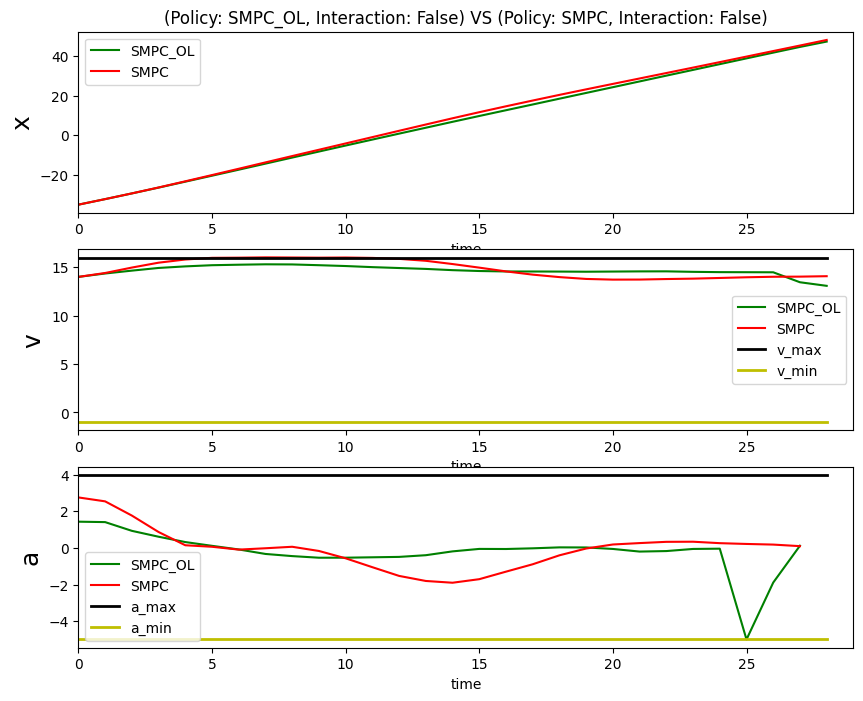

In [54]:
%matplotlib inline

fig=plt.figure(figsize=(10, 8))
t_f=max(Sim.t,Sim2.t)
a1=plt.subplot(311)
plt.plot(Sim.ev_traj[0,:Sim.t], color='g',linestyle='-', label=Sim.ev_pol)
plt.plot(Sim2.ev_traj[0,:Sim2.t], color='r',linestyle='-', label= Sim2.ev_pol)
plt.xlabel('time')
plt.ylabel('x',fontsize=18)
plt.xlim(0,t_f)
a1.set_title("(Policy: "+Sim.ev_pol+", Interaction: "+str(Sim.IA_flag)+")"+ " VS (Policy: "+Sim2.ev_pol+", Interaction: "+str(Sim2.IA_flag)+")")
plt.legend()
a2=plt.subplot(312)
plt.plot(Sim.ev_traj[2,:Sim.t], color='g',linestyle='-', label=Sim.ev_pol)
plt.plot(Sim2.ev_traj[2,:Sim2.t], color='r',linestyle='-', label= Sim2.ev_pol)
plt.plot(smpc2.V_MAX*np.ones(t_f), color='k',linewidth=2.0,linestyle='-', label= 'v_max')
plt.plot(smpc2.V_MIN*np.ones(t_f), color='y',linewidth=2.0,linestyle='-', label= 'v_min')
plt.xlabel('time')
plt.ylabel('v',fontsize=18)
plt.xlim(0,t_f)
plt.legend()
a3=plt.subplot(313)
plt.plot(Sim.ev_u[0,1:Sim.t], color='g',linestyle='-', label=Sim.ev_pol)
plt.plot(Sim2.ev_u[0,1:Sim2.t], color='r',linestyle='-', label= Sim2.ev_pol)
plt.plot(smpc2.A_MAX*np.ones(t_f), color='k',linewidth=2.0,linestyle='-', label= 'a_max')
plt.plot(smpc2.A_MIN*np.ones(t_f), color='y',linewidth=2.0,linestyle='-', label= 'a_min')
plt.xlabel('time')
plt.ylabel('a',fontsize=18)
plt.xlim(0,t_f)
plt.legend()

plt.show()

# plt.savefig(Sim.ev_pol+'_vs_'+Sim2.ev_pol+'_'+str(mode)+'.png')


## Animation for Policy 1

In [51]:
%matplotlib notebook

fig= plt.figure(figsize=[8,4])
camera = Camera(fig)


marker_list=[".","4"]
for i in range(Sim.t+1):
    plt.plot([-40, max([60,np.max(Sim.tv_traj[0][0,:])])], [12, 12], color='k', lw=2)
    plt.plot([50, 50], [-5, 12], '--', color='b', lw=1)
    plt.plot([-40, max([60,np.max(Sim.tv_traj[0][0,:])])], [-5, -5], color='k', lw=2)
    plt.plot([-40, max([60,np.max(Sim.tv_traj[0][0,:])])], [4, 4], color='k', lw=1)
    plt.plot(Sim.ev_traj[0,:i+1], Sim.ev_traj[1,:i+1], color='green', lw=3)
    
    plt.gca().add_patch(Rectangle((Sim.tv_traj[0][0,i]-2.9,Sim.tv_traj[0][1,i]-1.6),5.8,3.2,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim.ev_traj[0,i]-2.9,Sim.ev_traj[1,i]-1.6),5.8,3.2,linewidth=1,edgecolor='g',facecolor='none'))
    if i>0:
        if not feas_list[i-1]:
            plt.text(-20,20, "INFEASIBLE!", fontsize=10, color='r')
        if ca_list[i-1]:
            plt.text(-20,30, "Collision!", fontsize=15, color='r')
        if not np.isnan(EV_preds[i-1]).any():
            for j in range(smpc.N_modes):
                plt.plot(EV_preds[i-1][j][0,:],EV_preds[i-1][j][1,:], marker_list[j], color='green', alpha=0.3+j*0.5)
                for k in range(smpc.N_TV):
                    plt.plot(TV_preds[i-1][j][k][0,:],TV_preds[i-1][j][k][1,:],  marker_list[j], color='red', alpha=0.3+j*0.5)
   
    plt.axis('equal')
    plt.title("Policy type : "+Sim.ev_pol+"    Interaction : "+str(Sim.IA_flag))
    camera.snap()
    
animation = camera.animate(repeat = True, repeat_delay = 500)
HTML(animation.to_jshtml())
# animation.save('animation_'+Sim.ev_pol+'_'+str(mode)+'.mp4')


<IPython.core.display.Javascript object>

## Animation for Policy 2

In [57]:
%matplotlib notebook

fig= plt.figure(figsize=[8,4])
camera = Camera(fig)

marker_list=[".","4"]

for i in range(Sim2.t+1):
    plt.plot([-40, max([60,np.max(Sim2.tv_traj[0][0,:])])], [12, 12], color='k', lw=2)
    plt.plot([50, 50], [-5, 12], '--', color='b', lw=1)
    plt.plot([-40, max([60,np.max(Sim2.tv_traj[0][0,:])])], [-5, -5], color='k', lw=2)
    plt.plot([-40, max([60,np.max(Sim2.tv_traj[0][0,:])])], [4, 4], color='k', lw=1)
    plt.plot(Sim2.ev_traj[0,:i+1], Sim2.ev_traj[1,:i+1], color='green', lw=3)
    if i>0:
        if not feas_list2[i-1]:
            plt.text(-20,20, "INFEASIBLE!", fontsize=10, color='r')
        if ca_list2[i-1]:
            plt.text(-20,30, "Collision!", fontsize=15, color='r')
    plt.gca().add_patch(Rectangle((Sim2.tv_traj[0][0,i]-2.9,Sim2.tv_traj[0][1,i]-1.6),5.8,3.2,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim2.ev_traj[0,i]-2.9,Sim2.ev_traj[1,i]-1.6),5.8,3.2,linewidth=1,edgecolor='g',facecolor='none'))
    if i>0:
        if not feas_list2[i-1]:
            plt.text(-20,20, "INFEASIBLE!", fontsize=10, color='r')
        if ca_list2[i-1]:
            plt.text(-20,30, "Collision!", fontsize=15, color='r')
        if not np.isnan(EV_preds2[i-1]).any():
            for j in range(smpc2.N_modes):
                plt.plot(EV_preds2[i-1][j][0,:],EV_preds2[i-1][j][1,:], marker_list[j], color='green', alpha=0.2+j*0.5)
                for k in range(smpc2.N_TV):
                    plt.plot(TV_preds2[i-1][j][k][0,:],TV_preds2[i-1][j][k][1,:], marker_list[j], color='red', alpha=0.2+j*0.5)
                
    plt.axis('equal')
    plt.title("Policy type : "+Sim2.ev_pol+"    Interaction : "+str(Sim2.IA_flag))
    camera.snap()
    
animation = camera.animate(repeat = True, repeat_delay = 1000)
HTML(animation.to_jshtml())
# animation.save('animation_'+Sim2.ev_pol+'_'+str(mode)+'.mp4')


<IPython.core.display.Javascript object>